In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import collections

In [2]:
planets_train = pd.read_csv("C:/Users/user/.jupyter/주피터 파일/data/planets_train.csv")
planets_train.drop(['Unnamed: 0'], axis = 1, inplace = True)

planets_test = pd.read_csv("C:/Users/user/.jupyter/주피터 파일/data/planets_test.csv")
planets_test.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [3]:
train_x = planets_train.iloc[:, 1:6]
train_y = planets_train.iloc[:, 0]

test_x = planets_test.iloc[:, 1:6]
test_y = planets_test.iloc[:, 0]

In [4]:
train_y = train_y.where((train_y == 'Radial Velocity') | (train_y == 'Transit'), 'Others')
test_y = test_y.where((test_y == 'Radial Velocity') | (test_y == 'Transit'), 'Others')

In [5]:
train_x[['orbital_period', 'distance', 'mass']] = np.log(train_x[['orbital_period', 'distance', 'mass']])
test_x[['orbital_period', 'distance', 'mass']] = np.log(test_x[['orbital_period', 'distance', 'mass']])

In [6]:
train_x = train_x.interpolate()
test_x = test_x.interpolate()

In [7]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

train_x = RobustScaler().fit_transform(train_x)
test_x = RobustScaler().fit_transform(test_x)

In [8]:
from imblearn.over_sampling import SMOTE

x_train, y_train = SMOTE(random_state=0).fit_resample(train_x, train_y)
x_test, y_test = SMOTE(random_state=0).fit_resample(test_x, test_y)

In [9]:
y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

In [10]:
y_train_oh = pd.get_dummies(y_train).values
y_test_oh = pd.get_dummies(y_test).values

In [11]:
class Affine:
    def __init__(self,W,b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        self.dw = None
        self.db = None
    
    def backward(self,dout):
        dx = np.dot(dout,self.W.T)
        self.dw = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx
    
    def forward(self,x):

        self.x = x
        out = np.dot(self.x,self.W) + self.b
        return out

In [12]:
class ReLU():
    def __init__(self):
        self.parameter = {}
        self.mask = None
    
    def forward(self,x):
        y = x.copy()
        mask = (x<0)
        self.mask = mask
        y[mask] = 0 
        return y
    
    def backward(self,dy):
        mask=self.mask
        dx = dy.copy()
        dx[mask] = 0
        return dx

In [13]:
class Adam:
    def __init__(self,lr=0.001, beta1=0.9, beta2=0.99):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self,params,grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
                
        self.iter = 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)
        
        for key in params.keys():
            self.m[key] += (1-self.beta1) * (grads[key]-self.m[key])
            self.v[key] += (1-self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key])+1e-7)

In [14]:
class Dropout:
    def __init__(self,dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self,x, train_flag = True):
        if train_flag:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0-self.dropout_ratio)
    
    def backward(self, dout):
        return dout * self.mask

In [15]:
eps = 1e-8
class CrossEntropyWithSoftmax() :
    
    def __init__(self,reduction=True) :
        self.p_ = {}
        self.T = None
        self.Y = None
        self.reduction = reduction

    def forward(self,T,X) :
        self.T = T
        expX = np.exp(X-np.max(X))
        Y = expX/(eps + np.sum(expX,axis=1,keepdims=True))
        self.Y = Y
        loss = T*np.log(Y)
        
        if self.reduction :
            loss = -np.sum(loss)

        else :
            loss = -np.sum(loss,axis=1)

        return (loss, Y)

    def backward(self,dY) :
        T = self.T; Y = self.Y
        
        return Y - T

In [31]:
class Net():
    def __init__(self, input_size, hidden_size_list, output_size,
                activation='relu', weight_init_std = 'he', weight_decay_lambda=0,
                use_dropout=False, dropout_ration = 0.5):
        
        self.input_size = input_size
        self.hidden_size_list = hidden_size_list
        self.output_size = output_size
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.params ={}
        
        self.__init_weight(weight_init_std)
        
        activation_layer = {'relu':ReLU}
        self.layers = collections.OrderedDict()
        
        for idx in range(1,self.hidden_layer_num+1):
            self.layers['Affine'+str(idx)] = Affine(self.params['W'+str(idx)],
                                                   self.params['b'+str(idx)])
            
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            if self.use_dropout:
                self.layers['Dropout'+str(idx)] = Dropout(dropout_ration)
                
        
        idx = self.hidden_layer_num+1
        self.layers['Affine' + str(idx)] = Affine(self.params['W'+str(idx)],
                                                 self.params['b'+str(idx)])
        
        self.last_layer = CrossEntropyWithSoftmax()
        
    def __init_weight(self,weight_init_std):
        
        all_size_list = [self.input_size]+self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu','he'):
                scale = np.sqrt(2.0/all_size_list[idx-1])
            elif str(weight_init_std).lower() in ('sigmoid','xavier'):
                scale = np.sqrt(1.0/all_size_list[idx-1])
            self.params['W'+str(idx)] = scale*np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b'+str(idx)] = np.zeros(all_size_list[idx])
            
    def predict(self,x,train_flag = False):
        for key,layer in self.layers.items():
            if "Dropout" in key or "BacthNorm" in key:
                x = layer.forward(x,train_flag)
            else:
                x = layer.forward(x)
        return x
    
    def loss(self,x,t,train_flag = False):
        y = self.predict(x,train_flag)
        weight_decay = 0
        
        for idx in range(1,self.hidden_layer_num+2):
            W = self.params['W'+str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
        temp,_ = self.last_layer.forward(t,y)
        return  temp + weight_decay
    
    def accuracy(self,X,T):
        Y = self.predict(X, train_flag = False)
#         if T.ndim !=1:
#             T = np.argmax(T,axis=1)

        _, Y = self.last_layer.forward(T,Y)
        Y = np.argmax(Y,axis=1)
        T = np.argmax(T,axis=1)
        accuracy = np.mean(Y==T)*100
        return (Y,accuracy)
    


    def numerical_gradient(self,X,T):
        loss_W = lambda W: self.loss(X,T,train_flag = True)
        grads = {}
        
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W'+str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b'+str(idx)])
            
        return grads
    
    def gradient(self,x,t):
        self.loss(x,t,train_flag = True)
        
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}
        for idx in range(1,self.hidden_layer_num +2):
            grads['W' + str(idx)] = self.layers['Affine'+str(idx)].dw + self.weight_decay_lambda *self.params['W'+str(idx)]
            grads['b' + str(idx)] = self.layers['Affine'+str(idx)].db
            
        return grads

In [32]:
network = Net(input_size = 5, hidden_size_list = [64,256],output_size = 3,use_dropout=False)

In [33]:
optimizer = Adam(lr=0.001)

N = len(x_train)
batch_size = 16
Epochs = 30
iter_num = int(N/batch_size)

In [34]:
preds_list = []
loss_list = []

for epoch in range(Epochs):
    train_acc_batch = 0.0
    test_acc_batch = 0.0
    loss_temp = 0.0
    for j in range(iter_num):
        iter_n = batch_size * j
        x_batch = np.array(x_train)[iter_n:(iter_n+batch_size)]
        t_batch = np.array(y_train_oh)[iter_n:(iter_n+batch_size)]
        
        loss_temp += network.loss(x_batch,t_batch)
        
        grads = network.gradient(x_batch,t_batch)
        optimizer.update(network.params, grads)
        
        _,acc_tr = network.accuracy(x_batch, t_batch)
        preds, acc_te = network.accuracy(np.array(x_test),np.array(y_test_oh))
        train_acc_batch += acc_tr
        test_acc_batch += acc_te
        if (epoch == Epochs-1) and(j == iter_num-1):
            preds_list.extend(preds)
    train_loss = loss_temp / iter_num
    train_acc = train_acc_batch / iter_num
    test_acc = test_acc_batch / iter_num
    loss_list.append(train_loss)
    
    print("***%2dth epoch"%(epoch+1))
    print("Loss : {}".format(train_loss))
    print("Train acc : {}, Test acc : {}".format(train_acc, test_acc))

*** 1th epoch
Loss : 15.93706243942397
Train acc : 75.57565789473684, Test acc : 52.51361161524503
*** 2th epoch
Loss : 16.85076552513994
Train acc : 66.11842105263158, Test acc : 59.39806412583181
*** 3th epoch
Loss : 13.41471894538644
Train acc : 64.96710526315789, Test acc : 62.90986085904416
*** 4th epoch
Loss : 11.550320452209576
Train acc : 67.59868421052632, Test acc : 65.42649727767696
*** 5th epoch
Loss : 10.781486351553333
Train acc : 69.07894736842105, Test acc : 66.75438596491227
*** 6th epoch
Loss : 10.285756656395359
Train acc : 69.81907894736842, Test acc : 67.50756200846942
*** 7th epoch
Loss : 9.828620986714693
Train acc : 71.38157894736842, Test acc : 68.23956442831216
*** 8th epoch
Loss : 9.42928964928993
Train acc : 72.53289473684211, Test acc : 68.85057471264368
*** 9th epoch
Loss : 9.051222543088508
Train acc : 73.76644736842105, Test acc : 69.31941923774954
***10th epoch
Loss : 8.716206308913353
Train acc : 75.08223684210526, Test acc : 69.66122202056867
***11th 

In [39]:
_, test_acc = network.accuracy(x_test,y_test_oh)

print('test set -> acc: %5.2f%%'%(test_acc))

test set -> acc: 73.56%


In [21]:
true_label= np.array(y_test_oh)
tl_list=true_label.argmax(axis=1)

[Text(0, 0.5, 'Radial Velocity'),
 Text(0, 1.5, 'Transit'),
 Text(0, 2.5, 'Others')]

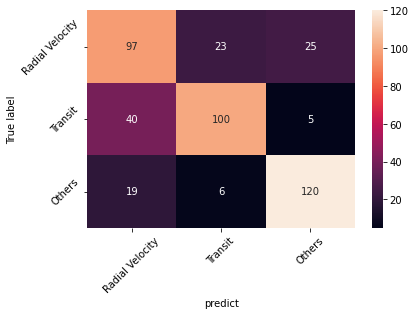

In [22]:
from sklearn.metrics import confusion_matrix

classes = ['Radial Velocity','Transit', 'Others']

cm = confusion_matrix(tl_list,preds_list)
c=sns.heatmap(cm,annot=True,fmt='g')
c.set(xlabel = "predict" , ylabel = "True label")
c.set_xticklabels(classes,rotation=45)
c.set_yticklabels(classes,rotation=45)